In [ ]:
# importing necessary packages for data analysis.
import numpy as np
import sys
sys.path.append("../../lhillber/brownian/src")
from time_series import CollectionTDMS as ctdms
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
# data from 07/17 Sagnac/Sagnac_fire_19J is complete shit
# we need to retake this data and make sure that the signal is being 
# taken correctly. For now, I'm using the data from 07/14 because it
# is a better representation of what our data should look like.
d = "../data/20230801/Sagnac/iter_0.tdms"
laser = ctdms(d)
micro = ctdms(d)
laser.set_collection("X")
laser.apply("detrend", mode = "linear", inplace = True)
laser.apply("calibrate", cal = -1, inplace = True)
micro.set_collection("Y")
fig, ax = plt.subplots()

shot = laser.collection[3]
shot.plot(tmin = 4.2e-4, tmax = 4.7e-4, ax = ax)
def friedlander(t, peak, tau):
    return peak * np.exp((-t / tau)) * (1 - (t / tau))

peak_index = np.where(shot.x == max(shot.x))[0][0]
z_crossing = peak_index + np.where(np.diff(np.sign(shot.x[peak_index:])))[0][0]
ax.scatter(shot.t[peak_index], shot.x[peak_index])
ax.scatter(shot.t[z_crossing], shot.x[z_crossing])
guess = np.array([shot.x[peak_index], shot.t[peak_index], shot.t[z_crossing]])
popt, pcov = curve_fit(friedlander, shot.t[peak_index : z_crossing + 500], shot.x[peak_index : z_crossing + 500], maxfev = 100000)
ax.plot(shot.t, friedlander(shot.t, *popt))
print(guess)
print(popt)
ax.set_xlim([4.2e-4, 4.7e-4])
ax.set_ylim([-1, 1.5])
plt.show()

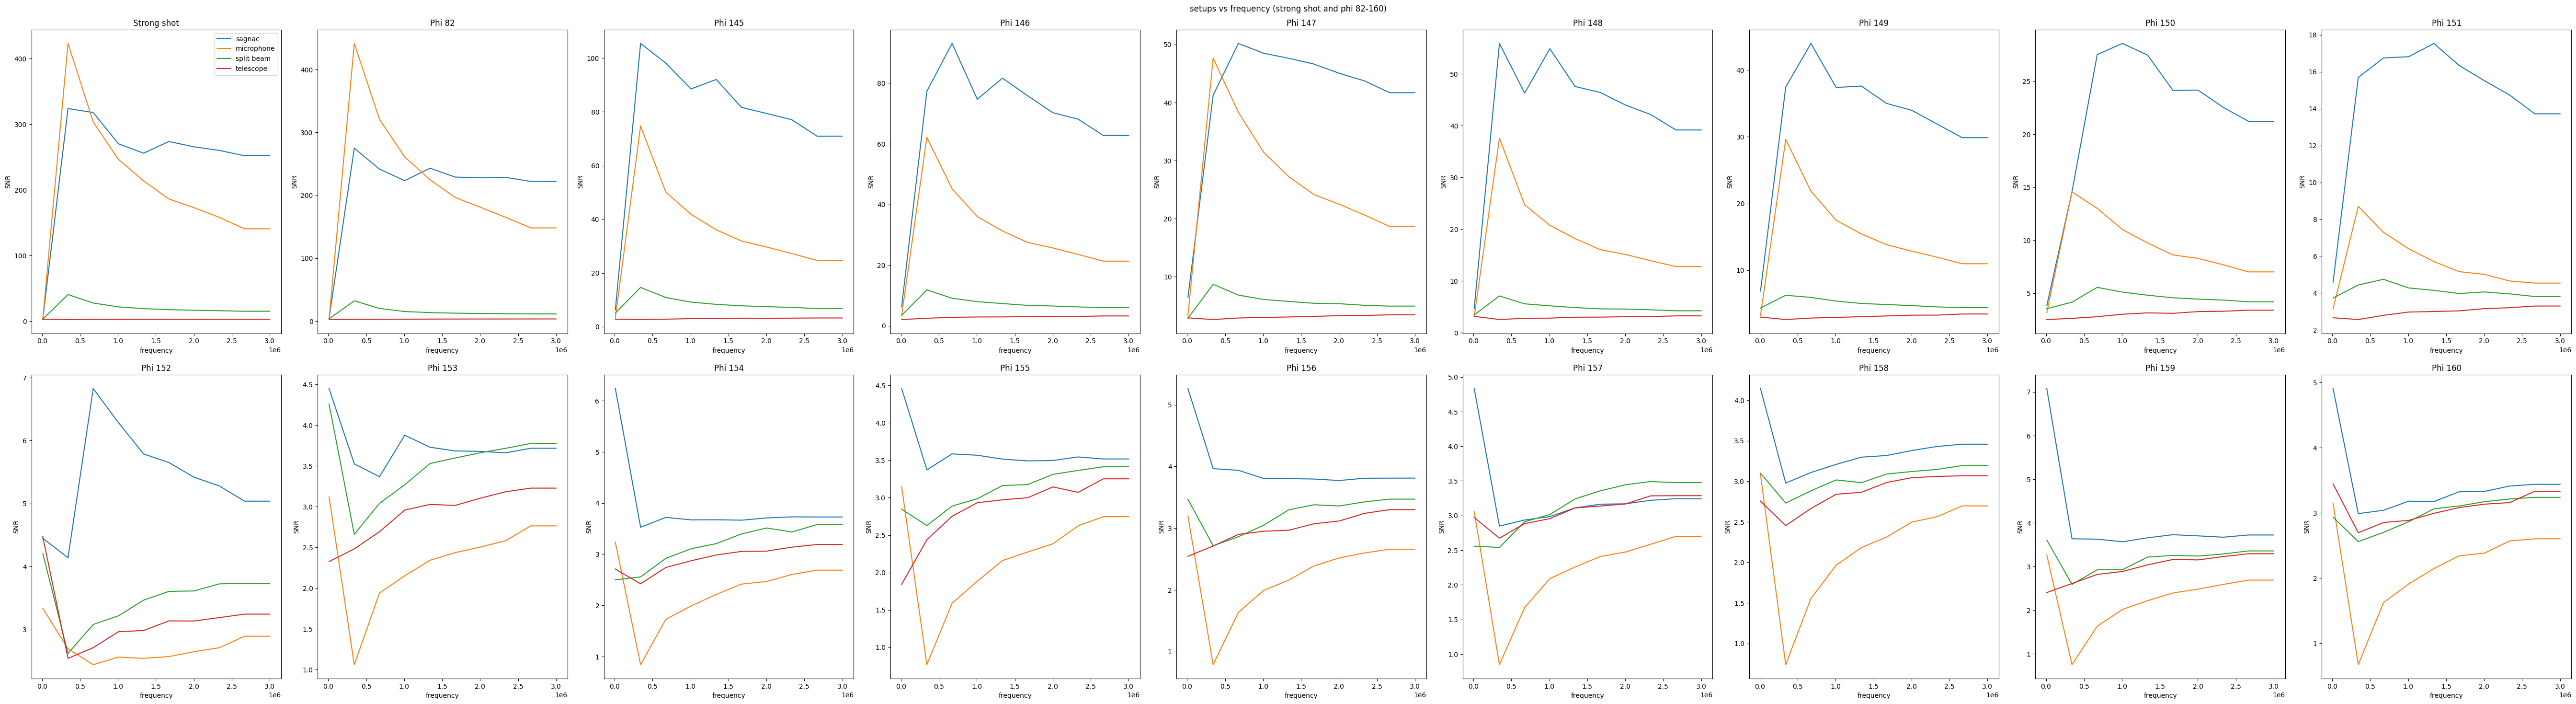

In [1]:
from analysis import System
import numpy as np

def graph_systems(systems = [], title = "", save = False) -> None:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.rcParams["figure.figsize"] = (54, 15)
    fig, ax = plt.subplots(2, 9)
    for s in systems:
        ax = ax.flatten()
        fig.suptitle("setups vs frequency (strong shot and phi 82-160)")
        for i in range(len(s.get_SNR_vs_freq()[0])):
            if i == 0:
                ax[i].set_title("Strong shot")
                ax[i].plot(s.get_SNR_freq_range(), s.get_SNR_vs_freq()[:, i], label = s.get_name())
                ax[i].set_ylabel("SNR")
                ax[i].set_xlabel("frequency")
            else:
                ax[i].set_title("Phi " + str(s.get_phis()[i - 1]))
                ax[i].plot(s.get_SNR_freq_range(), s.get_SNR_vs_freq()[:, i], label = s.get_name())
                ax[i].set_ylabel("SNR")
                ax[i].set_xlabel("frequency")
    fig.tight_layout(pad = 1.5)
    ax[0].legend()
    if save:
        fig.savefig(title)
    plt.show()
    return None

cutoff = 3e6
names = [("sagnac", "Sagnac"), ("microphone", "Sagnac"), ("split beam", "SplitBeam"), ("telescope", "Telescope")]
phis = ["phi" + str(int(np.append(82, np.linspace(145, 160, 16))[i])) + ".tdms" for i in range(len(np.append(82, np.linspace(145, 160, 16))))]
systems = np.array([])
for n in names:
    systems = np.append(systems, System(n[0], ["../data/20230801/" + n[1] + "/iter_0.tdms"] + ["../data/20230801/" + n[1] + "/MinDetect/" + i for i in phis], SNR_freq_cut = cutoff, phis = [int(p[3:-5]) for p in phis],  SNR_freq_range = [10000, cutoff], SNR_resolution = 10))
for s in systems:
    s.calc_SNR_vs_freq(bins = True)
graph_systems(systems, "bins: setups vs frequency with phi scan.png", True)

In [ ]:
from acoustic_entrainment import mic_response
plt.rcParams["figure.figsize"] = (12, 5)
ind = 0
freq = 1.2e5
fig, ax = plt.subplots()
systems[1].set_data(ind = ind)
mic_strong = systems[1].get_data()[ind]
mic_strong.apply("bin_average", Npts = int(mic_strong.r / (2 * freq)), inplace = True)
systems[1].local_detrend(index = ind, tmin = 0, tmax = 3.5e-4, inplace = True)
peaks = np.array([])
rms = np.array([])
for c in mic_strong.collection[1:]:
    ax.plot(c.t, c.x)
    peaks = np.append(peaks, np.abs(max(c.time_gate(tmin = 3.5e-4, tmax = 5e-4)[1])))
    rms = np.append(rms, np.std(c.time_gate(tmin = 2e-4, tmax = 3.5e-4)[1]))
mic_strong.aggrigate(collection_slice = slice(1, len(mic_strong.collection), 1))
mic_strong.agg.plot(label = systems[1].get_name(), ax = ax, c = "k")
plt.legend()
plt.show()
print("mic SNR")
print(np.abs(np.max(mic_strong.agg.time_gate(tmin = 3.5e-4, tmax = 5e-4)[1])) / np.std(mic_strong.agg.time_gate(tmin = 2e-4, tmax = 3.5e-4)[1]))
print(np.mean(peaks / rms))
print(systems[1].get_SNR_vs_freq()[:, 0])

fig, ax = plt.subplots()
systems[0].set_data(ind = ind)
laser_strong = systems[0].get_data()[ind]
laser_strong.apply("bin_average", Npts = int(laser_strong.r / (2 * freq)), inplace = True)
systems[0].local_detrend(index = ind, tmin = 0, tmax = 3.5e-4, inplace = True)
peaks = np.array([])
rms = np.array([])
for c in laser_strong.collection[1:]:
    ax.plot(c.t, c.x)
    peaks = np.append(peaks, np.abs(max(c.time_gate(tmin = 3.5e-4, tmax = 5e-4)[1])))
    rms = np.append(rms, np.std(c.time_gate(tmin = 2e-4, tmax = 3.5e-4)[1]))
ax.plot(laser_strong.collection[1].t, laser_strong.collection[1].x)
laser_strong.aggrigate(collection_slice = slice(1, len(laser_strong.collection), 1))
laser_strong.agg.plot(label = systems[0].get_name(), ax = ax, c = "k")
plt.legend()
plt.show()
print("sagnac SNR")
print(np.abs(np.max(laser_strong.agg.time_gate(tmin = 3.5e-4, tmax = 5e-4)[1])) / np.std(laser_strong.agg.time_gate(tmin = 2e-4, tmax = 3.5e-4)[1]))
print(np.mean(peaks / rms))
print(systems[0].get_SNR_vs_freq()[:, 0])